# Differentiate players between teams

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [22]:
from ai.config import PROJ_ROOT
!nvidia-smi

Tue Jan 14 22:39:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P8             13W /   25W |     413MiB /   6144MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install dependencies


Let's install the `inference-gpu` library, which will be used to efficiently run our object detection and keypoint detection models on GPUs. `inference-gpu` utilizes the `onnxruntime-gpu` library internally for optimal performance. We'll install a specific version of `onnxruntime-gpu` to guarantee compatibility with the CUDA 12.

In [29]:
!python -m pip install -q gdown inference-gpu
!python -m pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

Let's install PyTorch library, but make sure you're installing version compatible with your environment: https://pytorch.org/get-started/locally/

In [23]:
!python -m pip install torch torchvision torchaudio

Let's install ultralytics library.

In [24]:
!python -m pip install ultralytics

Let's make sure we have the latest features in the supervision library by installing version `0.23.0` or higher.

In [25]:
!python -m pip install supervision==0.23.0

## Load player detection model

In [41]:
import os
import torch
from pathlib import Path
from inference import get_model
from ultralytics import YOLO


NOTEBOOK_PATH = Path(os.getcwd())

DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.mps.is_available():
    DEVICE = "mps"

PLAYER_DETECTION_MODEL_PATH = "../models/player_inference.pt"
# PLAYER_DETECTION_MODEL = get_model(model_id=str(PLAYER_DETECTION_MODEL_PATH))
PLAYER_DETECTION_MODEL = YOLO(PLAYER_DETECTION_MODEL_PATH).to(DEVICE)

## Split players into teams

### Gathering training data

To gather training data, we'll sample one frame per second, detect players within those frames, and then crop them out.

In [52]:
import supervision as sv
from tqdm import tqdm


SOURCE_VIDEO_PATH = "../data/test.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []

for frame in tqdm(frame_generator, desc="collecting crops"):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)[0]

    detections = sv.Detections.from_ultralytics(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]

    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 22 players, 3 referees, 94.8ms
Speed: 23.1ms preprocess, 94.8ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 1it [00:00,  6.64it/s]


0: 736x1280 20 players, 3 referees, 96.7ms
Speed: 7.7ms preprocess, 96.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 2it [00:00,  7.22it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 89.9ms
Speed: 10.4ms preprocess, 89.9ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 3it [00:00,  7.70it/s]


0: 736x1280 21 players, 3 referees, 83.6ms
Speed: 9.2ms preprocess, 83.6ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 4it [00:00,  8.08it/s]


0: 736x1280 21 players, 3 referees, 85.6ms
Speed: 9.9ms preprocess, 85.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 5it [00:00,  8.30it/s]


0: 736x1280 1 goalkeeper, 23 players, 3 referees, 86.5ms
Speed: 9.3ms preprocess, 86.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 6it [00:00,  8.41it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 88.0ms
Speed: 8.2ms preprocess, 88.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 7it [00:00,  8.46it/s]


0: 736x1280 1 goalkeeper, 19 players, 3 referees, 86.6ms
Speed: 7.5ms preprocess, 86.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 8it [00:00,  8.51it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 86.1ms
Speed: 9.0ms preprocess, 86.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 9it [00:01,  8.58it/s]


0: 736x1280 2 goalkeepers, 19 players, 2 referees, 86.6ms
Speed: 8.3ms preprocess, 86.6ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 10it [00:01,  8.62it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 86.3ms
Speed: 9.4ms preprocess, 86.3ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 11it [00:01,  8.62it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 87.1ms
Speed: 9.8ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 12it [00:01,  8.61it/s]


0: 736x1280 2 goalkeepers, 20 players, 3 referees, 91.7ms
Speed: 8.3ms preprocess, 91.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 13it [00:01,  8.56it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 86.5ms
Speed: 10.0ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 14it [00:01,  8.59it/s]


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 87.0ms
Speed: 8.2ms preprocess, 87.0ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 15it [00:01,  8.65it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 87.2ms
Speed: 8.4ms preprocess, 87.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 16it [00:01,  8.68it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 86.0ms
Speed: 9.1ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 17it [00:02,  8.74it/s]


0: 736x1280 1 goalkeeper, 18 players, 2 referees, 87.2ms
Speed: 7.9ms preprocess, 87.2ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 18it [00:02,  8.71it/s]


0: 736x1280 21 players, 2 referees, 87.1ms
Speed: 8.7ms preprocess, 87.1ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 19it [00:02,  8.69it/s]


0: 736x1280 19 players, 3 referees, 87.5ms
Speed: 9.4ms preprocess, 87.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 20it [00:02,  8.67it/s]


0: 736x1280 19 players, 2 referees, 87.4ms
Speed: 8.4ms preprocess, 87.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 21it [00:02,  8.68it/s]


0: 736x1280 18 players, 5 referees, 86.5ms
Speed: 8.3ms preprocess, 86.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 22it [00:02,  8.71it/s]


0: 736x1280 1 goalkeeper, 17 players, 4 referees, 83.5ms
Speed: 10.6ms preprocess, 83.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 23it [00:02,  8.54it/s]


0: 736x1280 19 players, 4 referees, 84.3ms
Speed: 8.6ms preprocess, 84.3ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 24it [00:02,  8.60it/s]


0: 736x1280 19 players, 4 referees, 86.2ms
Speed: 7.6ms preprocess, 86.2ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


collecting crops: 25it [00:02,  8.48it/s]


In [53]:
crops

[array([[[ 48, 119,  95],
         [ 48, 119,  95],
         [ 48, 119,  95],
         ...,
         [ 49, 123, 100],
         [ 49, 123, 100],
         [ 49, 123, 100]],
 
        [[ 48, 119,  95],
         [ 48, 119,  95],
         [ 48, 119,  95],
         ...,
         [ 49, 123, 100],
         [ 49, 123, 100],
         [ 50, 124, 101]],
 
        [[ 50, 121,  97],
         [ 48, 119,  95],
         [ 48, 119,  95],
         ...,
         [ 50, 124, 101],
         [ 50, 124, 101],
         [ 50, 124, 101]],
 
        ...,
 
        [[ 41,  97,  79],
         [ 35,  89,  71],
         [ 43,  97,  79],
         ...,
         [ 32,  85,  70],
         [ 39,  92,  77],
         [ 47, 100,  85]],
 
        [[ 51, 107,  89],
         [ 39,  93,  75],
         [ 31,  85,  67],
         ...,
         [ 50, 103,  88],
         [ 51, 104,  89],
         [ 53, 106,  91]],
 
        [[ 57, 113,  95],
         [ 55, 109,  91],
         [ 42,  96,  78],
         ...,
         [ 58, 113,  98],
  

In [54]:
len(crops)

70

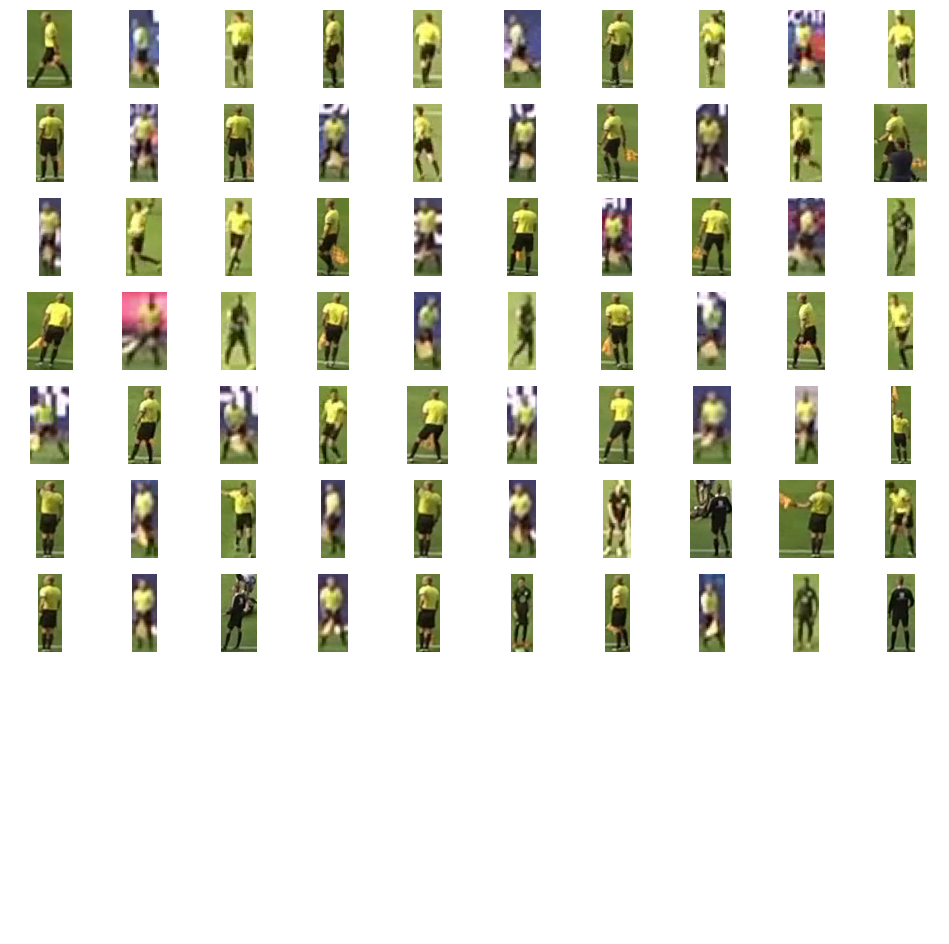

In [55]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

### Calculating embeddings for each of the crops